In [54]:
import numpy as np
import matplotlib.pyplot as plt

def Eloss(Ep, trial_z):#Test energy loss to this point
    prange = 0.0237*Ep**2 + 0.0369*Ep - 0.0102 #mm -- range of proton from SRIM
    if trial_z > prange:
        return 0
    else:
        prange -= trial_z
    return -7.98*prange**2 + 10.0761*prange + 0.6029 #MeV
def InteractionE(Ep=2.6):
    trials_max = 1000
    max_depth = 0.2 #mm -- maximum depth the p can interact with (to be safe)
    XSmax = np.max(gXS_t[:,1])
    for trial in range(trials_max):
        excited = False
        trial_z = max_depth * np.random.rand()
        energy = Eloss(Ep,trial_z) #Get energy loss of initial Ep, through trial_z mm of Li to give new energy
        if energy<=Eth:
            continue
        else:
            XS = np.interp(energy,gXS_t[:,0], gXS_t[:,1])
            if energy < 1.925:#Use Lee and Zhou formulation for lower energy rather than data
                x = 6*np.sqrt(1-Eth/energy)
                XS = (4*np.pi*164.913*x)/ (energy*(1+x)**2)
            XS_0 = np.interp(energy,gXS_0[:,0], gXS_0[:,1])
            XS_1 = np.interp(energy,gXS_1[:,0], gXS_1[:,1])
            if energy > 2.5 and np.random.rand()< (XS_1/(XS_1 + XS_0)):
                excited = True
            if XS > XSmax * np.random.rand(): #accept
                return energy,excited
    raise Exception(f"Reached {trials_max} trials without a solution in InteractionE- check the programme")

def InteractionTheta(Ep,excited):
    random_theta = np.random.uniform(0,2*np.pi) #0->2pi random theta
    if(Ep < 1.95):
        A = np.array([1,0,0])
    else:
        if excited: #Get excited legendre co-efficients
            A = np.array([np.interp(Ep,gB[:,0], gB[:,1]),np.interp(Ep,gB[:,0], gB[:,2]),np.interp(Ep,gB[:,0], gB[:,3])])
        else: #Get g.s. legendre coefficients
            A = np.array([np.interp(Ep,gA[:,0], gA[:,1]),np.interp(Ep,gA[:,0], gA[:,2]),np.interp(Ep,gA[:,0], gA[:,3])])

    max_samples = 1000
    XSmax = 3
    for sample in range(max_samples):
        XS_sample = np.random.uniform(0,XSmax) #Sample a diff XS at an undefined angle
        th_sample = np.random.uniform(0,2*np.pi)
        XS = np.sin(th_sample)*(A[0] + A[1]*np.cos(th_sample) + A[2]*0.5*(3*np.cos(th_sample)**2 - 1))
        if XS>XSmax:
            raise Exception("XS exceeds XSmax in InteractionTheta")
        if XS_sample < XS:#Accept
            return th_sample
    raise Exception(f"Reached {trials_max} trials without a solution in InteractionTheta - check the programme")


# def ConvertCMtoLab(Eint,thetaCM,excited):
#     Ex = 0
#     if excited:
#         Ex = 0.477
#     gamma = np.sqrt( (mp*mn) / (mBe*mLi)) * Ep / (Ep + (Q - Ex)*(1+mp/mLi)) #Gamma for conversion to lab COM
#     gamma *= (mp + mLi) / (mn + mBe) # account for change in the COM velocity (usually ignored but important)
#     thetalab = np.arctan2(np.sin(thetaCM),np.cos(thetaCM)+gamma)
#     secondks = False
#     if(gamma*np.cos(thetaCM)<=-1):#Second Kinematic solution (neutrn going backwards)
#         secondks = True
#     return thetalab,secondks

def NeutronEnergy(Eint,thetaCM,excited):
    Ex=0
    if excited:
        Ex=0.431 #MeV
    ECM = mLi*Eint/(mLi+mp)+Q-Ex #COM energy
    p_nT = np.sqrt(2*ECM*mn*(mBe/(mn+mBe))) #transverse energy taken by neutron in COM
    phi = np.random.uniform(0,2*np.pi)
    pn = np.array([p_nT*np.sin(thetaCM)*np.cos(phi), p_nT*np.sin(thetaCM)*np.sin(phi), p_nT*np.cos(thetaCM)])#COM neutron momentum
    pn[2] += (mp/(mp+mLi))*np.sqrt(2*mp*Ep) #Add momentum boost to get to lab frame
    En_new = (np.linalg.norm(pn)**2)/(2*mn)
    # En_new = (pn[0]**2 + pn[1]**2 + pn[2]**2)/(2*mn)
    theta_lab = np.arccos(pn[2]/np.linalg.norm(pn))
    return En_new, theta_lab


mp=1.007276 
mn=1.008665
mLi=7.01435712 #Nuclear
mBe=7.01473382 #Nuclear
Q=-1.64424;
Eth = 1.88035 #Threshold energy for 7Li(p,n) reaction

#Load 7Li(p,n_tot) XS data file


gXS_t = np.loadtxt("XS_t.txt")
gXS_0 = np.loadtxt("XS_0.txt") #7Be(g.s)
gXS_1 = np.loadtxt("XS_1.txt") #7Be excited state
gA = np.loadtxt("XS_ang0.txt") #Legendre co-efficients for g.s
gB = np.loadtxt("XS_ang1.txt") #Legendre co-efficients for excited


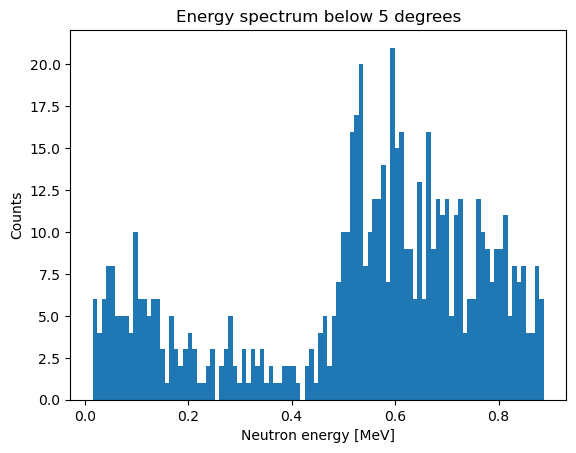

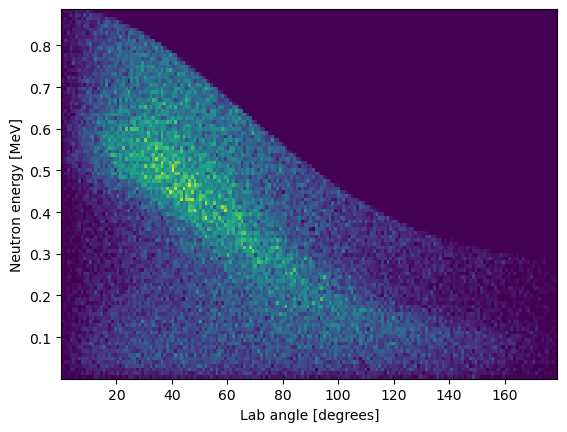

In [62]:

nsamples = 100000 #Choose how many samples you want
Ep = 2.6 #Choose proton energy
En = [] #list for neutron energy
thl = [] #list for theta lab
for n in range(nsamples):
    Eint, excited = InteractionE(Ep) #Get interaction E
    thetaCM = InteractionTheta(Eint, excited) #Get theta in COM from diff XS
    Eneutron, thetalab = NeutronEnergy(Eint,thetaCM,excited) #Get the lab neutron E
    En.append(Eneutron) 
    thl.append(thetalab)
En = np.array(En)#turn into np array
thl = np.array(thl)#turn into np array

theta_d = 5 #Show spectrum only below 5 degrees for example
plt.hist(En[np.where(thl<np.radians(theta_d) )],bins=100)#Mask with only theta lab below theta_d
plt.title(f"Energy spectrum below {theta_d} degrees")
plt.xlabel("Neutron energy [MeV]")
plt.ylabel("Counts")
plt.show()
plt.hist2d(np.degrees(thl),En,bins=(180,100))
plt.xlabel("Lab angle [degrees]")
plt.ylabel("Neutron energy [MeV]")
plt.show()